## 引用函式庫

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 準備資料集

In [ ]:
## 定義圖片路徑
trainPath = '/content/drive/MyDrive/Class/第三次助教課/train'
validationPath = '/content/drive/MyDrive/Class/第三次助教課/valid'
testPath = '/content/drive/MyDrive/Class/第三次助教課/test'

## 定義基本參數
imageSize = (224, 224)
imageShape = (224, 224, 3)
numofClass = 2
batchSize = 8
epoch = 20

## 定義 ImageDataGenerator (train)
trainDataGenerator = ImageDataGenerator(rescale = 1 / 255,
                      rotation_range=40, 
                      width_shift_range = 0.3,
                      height_shift_range = 0.3,
                      shear_range = 0.3,
                      zoom_range = 0.2,
                      horizontal_flip = True,
                      fill_mode = 'nearest')
trainBatches = trainDataGenerator.flow_from_directory(directory = trainPath,
                            target_size = imageSize,
                            interpolation = 'bicubic',
                            class_mode = 'categorical',
                            shuffle = True,
                            batch_size = batchSize)

## 定義 ImageDataGenerator (validation)
validateDataGenerator = ImageDataGenerator()
validateBatches = validateDataGenerator.flow_from_directory(directory = validationPath,
                            target_size = imageSize,
                            interpolation = 'bicubic',
                            class_mode = 'categorical',
                            shuffle = False,
                            batch_size = batchSize)

Found 322 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [ ]:
for cls, idx in trainBatches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

Class #0 = BANDED BROADBILL
Class #1 = BIRD OF PARADISE


## 建立 Transfer Learning 模型

In [ ]:
myModel = VGG16(include_top = False,
            weights = 'imagenet',
            input_tensor = None,
            input_shape = imageShape)

x = myModel.output
x = GlobalAveragePooling2D()(x)
x = Dense(units = 512, activation = 'relu')(x)
x = Dense(units = 64, activation = 'relu')(x)
output_layer = Dense(units = numofClass, activation = 'softmax')(x)

myModel.trainable = False
finalModel = Model(inputs = myModel.input, outputs = output_layer)

finalModel.compile(optimizer = Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

finalModel.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
finalModel.fit_generator(trainBatches,
              steps_per_epoch = trainBatches.samples // batchSize,
              validation_data = validateBatches,
              validation_steps = validateBatches.samples // batchSize,
              epochs = epoch)
finalModel.save('/content/drive/MyDrive/Class/第三次助教課/finalModel.h5')

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


40/40 [==============================] - 25s 640ms/step - loss: 0.3358 - accuracy: 0.8376 - val_loss: 0.5555 - val_accuracy: 0.8750
Epoch 2/20
40/40 [==============================] - 7s 165ms/step - loss: 0.3303 - accuracy: 0.8503 - val_loss: 9.7748e-06 - val_accuracy: 1.0000
Epoch 3/20
40/40 [==============================] - 7s 165ms/step - loss: 0.1723 - accuracy: 0.9331 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/20
40/40 [==============================] - 7s 165ms/step - loss: 0.2169 - accuracy: 0.9076 - val_loss: 9.2338e-05 - val_accuracy: 1.0000
Epoch 5/20
40/40 [==============================] - 7s 164ms/step - loss: 0.2519 - accuracy: 0.8885 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/20
40/40 [==============================] - 7s 166ms/step - loss: 0.1449 - accuracy: 0.9236 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/20
40/40 [==============================] - 7s 167ms/step - loss: 0.1023 - accuracy: 0.9618 - val_loss: 0.0000e+00 - val_accuracy:

## Occlusion

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
import seaborn as sn

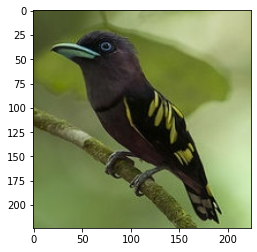

In [ ]:
baseImage = cv2.imread('/content/drive/MyDrive/Class/第三次助教課/valid/BANDED BROADBILL/1.jpg')
plt.imshow(baseImage[:, :, ::-1])

100%|██████████| 200/200 [1:02:18<00:00, 18.69s/it]


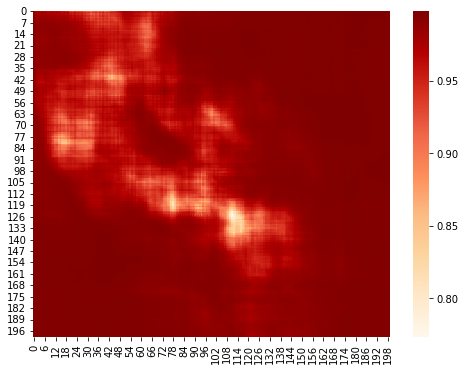

In [ ]:
coverRegion = [50, 50, 3]
paddingSize = int((coverRegion[0] - 1) / 2)
resultHeatmap = np.zeros((baseImage.shape[0] - paddingSize, baseImage.shape[1] - paddingSize))
test = np.copy(baseImage)

finalModel = keras.models.load_model('/content/drive/MyDrive/Class/第三次助教課/finalModel.h5')

for rowIndex in trange(baseImage.shape[0] - paddingSize):
  for colIndex in range(baseImage.shape[1] - paddingSize):
    test = np.copy(baseImage) / 255
    test[rowIndex:rowIndex+coverRegion[0], colIndex:colIndex+coverRegion[1], :] = np.full_like(coverRegion, fill_value = 1)
    test = test.reshape((1, test.shape[0], test.shape[1], test.shape[2]))
    thisResult = finalModel.predict(test)
    thisResult = thisResult[0, 0]
    resultHeatmap[rowIndex, colIndex] = thisResult

fig = plt.figure(figsize=(8, 6))
sn.heatmap(resultHeatmap, cmap="OrRd", fmt='g')
plt.show()


# plt.imshow(test.reshape[:, :, ::-1])
# baseImage.shape[0] - paddingSize
# baseImage.shape[1] - paddingSize